<a href="https://colab.research.google.com/github/SeanSDarcy2001/CISProgrammingAssignments/blob/main/downstream/deepDRRnoduleInsertion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install deepdrr

     |████████████████████████████████| 14.7 MB 14.6 MB/s 
     |████████████████████████████████| 232 kB 10.0 MB/s 
     |████████████████████████████████| 1.7 MB 12.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 58.3 MB/s 
     |████████████████████████████████| 1.4 MB 52.9 MB/s 
     |████████████████████████████████| 68 kB 9.1 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
     |████████████████████████████████| 88.3 MB 110 kB/s 
     |████████████████████████████████| 51 kB 9.2 MB/s 
     |████████████████████████████████| 1.1 MB 60.9 MB/s 
     |████████████████████████████████| 144 kB 64.0 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 76.7 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=96c3d28e36b37b884d0f4da710cbe

In [2]:
from google.colab import drive
drive.mount('gdrive/')
nodulePath = "gdrive/My Drive/deepDRR_3dseg/SegNod3.nii.gz"
CTPath = "gdrive/My Drive/deepDRR_3dseg/thinSTtorso.nii.gz"
lungSegPath = "gdrive/My Drive/deepDRR_3dseg/lungSeg.nii.gz"

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


In [50]:
import deepdrr
from deepdrr import Volume, geo
import numpy as np
from scipy.spatial.transform import Rotation as R
import random

random.seed(9)
#nodulesToInsert = #random int (0 - 6)

NodPath = nodulePath
OrganPath = lungSegPath
CTPath = CTPath

carm = deepdrr.MobileCArm()

def getNodule(path) -> Volume :
    nodule = Volume.from_nifti(path)
    return nodule

def getOrgan(path) -> Volume :
    organ = Volume.from_nifti(path)
    return organ

def scaleNodule(x) -> Volume :
    scaleFactor = random.uniform(0.0, 1.5)
    scaleMatrix = np.array([[scaleFactor, 0.0, 0.0, 0.0], [0.0, scaleFactor, 0.0, 0.0], [0.0, 0.0, scaleFactor, 0.0], [0.0, 0.0, 0.0, 1.0]])
    scaling = geo.FrameTransform(scaleMatrix)
    x.world_from_anatomical = scaling @ x.world_from_anatomical
    return x

    #scale function?
    #edit values in world from anatomical OR anatomical from world
    #ijk from anatomical should be const


def rotNodule(x) -> Volume :
    rotation = R.random()
    x = x.rotate(rotation)
    return x

#modified np.all
def contains(org: Volume, x: geo.Point3D) -> bool:
    """Determine whether the point x is inside the volume.
    Args:
        x (geo.Point3D)world': [-1346.4464, -65.99151, 8.187973], 'fractured': False,
                          'cortical_breach': 'TODO'}: world-space point.
    """
    x_ijk = np.array(org.ijk_from_world @ geo.point(x))
    if not np.all(0 <= x_ijk) and np.all(x_ijk < np.array(org.shape)):
        return False
    
    i, j, k = np.round(x_ijk).astype(int)
    return org.data[i, j, k] > 0

def translate_center_to(nod : Volume, x: geo.Point3D) -> None:
        """Translate the volume so that its center is located at world-space point x.
        Only changes the translation elements of the world_from_anatomical transform. Preserves the current rotation of the
        Args:
            x (geo.Point3D): the world-space point.
        """

        x = geo.point(x)
        nod.translate(x - nod.center_in_world)
        return nod

def insertNodule(org) :
    boundingBox = org.get_bounding_box_in_world()
    pointInOrgan = False
    while not pointInOrgan:
        point = geo.point(np.random.uniform(boundingBox[0], boundingBox[1], size=3))
        pointInOrgan = contains(org, point)
    
    #x = randomly sample point in bounding box, if bounding box is circuscribed about segmentation, check if point is within organ still, if not sample anothe point (while)
    #output volume object
    #when passed to the projector
    
    #x = x.translate_center_to(point), will do outside
    x = point
    print(x)
    return x



##main here 
#for each segmented CT volume, insert nodulesToInsert

nodule = getNodule(NodPath)

#organ and CT can use same method?
organ = getOrgan(OrganPath)
#ct = getOrgan(CTPath)

#rotate, scale, and translate a nodule
nodule = rotNodule(nodule)
#print(nodule)
nodule = scaleNodule(nodule)
#print(nodule)
point = insertNodule(organ)
nodcent = nodule.center_in_world
print("Pre Trans Center:", nodcent)
print("Target:", point)
nodule = translate_center_to(nodule, point)
print("Post Trans center:", nodule.center_in_world)


#figure out how to move carm to main view 
#carm.move_to(**main_view)

carm.move_to(isocenter=organ.center_in_world, alpha=45, beta=30, degrees=True)
#start up the projectors
volume_projector = deepdrr.Projector([organ, nodule], carm=carm) #what is **self.seg_projector_config #add ct before nodule when not in collab
gt_projector = deepdrr.Projector(nodule, carm=carm)

volume_projector.initialize()
gt_projector.initialize()





#get image
image = volume_projector()

#get ground truth and mask
nodule_heatmap = gt_projector()
nodule_mask = np.where(nodule_heatmap > 0, 1, 0).astype(np.float32)

[  -5.5182734 -141.22673   -136.05064      1.       ]
Pre Trans Center: [-33.92736 -39.6766  -50.35205   1.     ]
Target: [  -5.5182734 -141.22673   -136.05064      1.       ]
Post Trans center: [  -5.5182734 -141.22673   -136.05064      1.       ]


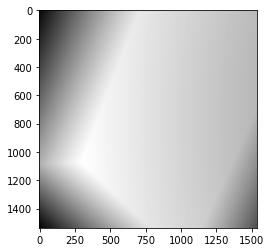

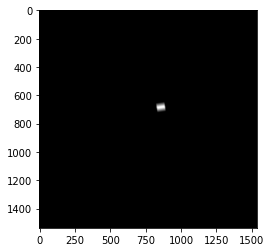

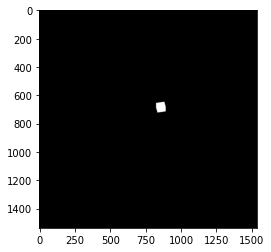

In [51]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')
plt.show()

plt.imshow(nodule_heatmap, cmap='gray')
plt.show()

plt.imshow(nodule_mask, cmap='gray')
plt.show()
